In [35]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import scipy.signal as signal


In [36]:

def filter_timeseries(ts, order, cutoff, btype='lowpass', fs=1, **kwargs):
    """Given an array, this function apply a butterworth (high/low pass) 
    filter of the given order and cutoff frequency.
    For example:
    If 'ts' is a timeseries of daily samples, filter_timeseries(ts,3,1/20)
    will return the series without the 20 days or less variability using an
    order 3 butterworth filter. 
    In the same way, filter_timeseries(ts,3,1/20, btype='highpass') will
    return the series with only the 20 days or less variability.

    Args:
        ts (array_like): timeseries or 1D array to filter
        order (int): _description_
        cutoff (array_like): Single float for lowpass or highpass filters, 
        arraylike for bandpass filters.
        btype (str, optional): The type of filter. Defaults to 'lowpass'.
        fs (int): Sampling frequency. Defaults to 1
        **kwargs are passed to scipy.signal.filtfilt

    Returns:
        output (array): Filtered array
    """
    mask = np.isnan(ts)
    nans = np.ones(len(ts))*np.nan
    if mask.sum()==len(ts):
        return nans
    else:
        b, a = signal.butter(order, cutoff, btype=btype, fs=fs)
        filt=signal.filtfilt(b, a, ts[~mask], **kwargs)
        output=np.ones(len(ts))*np.nan
        output[np.where(~mask)] = filt
        return output
    
def filter_xarray(data, dim, order, cutoff, btype='lowpass', parallel=False, fs=1):
    """Given a 3d DataArray, with time and spatial coordinates, this function apply
    the 1D function filter_timeseries along the time dimension, filter the complete
    xarray data.

    Args:
        data (XDataArray): data
        dim (str): name of the time dimension
        order (int): butterworth filter order
        cutoff (array_like): if float, the cutoff frequency, if array must be the
                            [min,max] frequencys for the bandpass filter.
        btype (str, optional): {lowpass,highpass,bandpass}. Defaults to 'lowpass'.
        parallel (bool, optional): If parallelize with dask. Defaults to False.
        fs (int, optional): Sampling frequency. Defaults to 1.

    Returns:
        XDataArray: filtered data
    """
    if parallel:
        dask='parallelized'
    else:
        dask='forbidden'
    filt = xr.apply_ufunc(filter_timeseries, data, order, cutoff, btype, fs,
                          input_core_dims=[[dim],[],[],[],[]],
                          output_core_dims=[[dim]],
                          exclude_dims=set((dim,)),
                          keep_attrs=True,
                          vectorize=True, dask=dask)
    filt[dim] = data[dim]
    return filt



In [2]:
tropical_glorys       = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/glorys_tropical.nc').convert_calendar('noleap', dim='time')
coastnorth_glorys     = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/glorys_coastnorth.nc').convert_calendar('noleap', dim='time')
coastsouth_glorys     = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/glorys_coastsouth.nc').convert_calendar('noleap', dim='time')

tropical_glorys_clim       = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/CLIMATOLOGY/glorys_tropical.nc')
coastnorth_glorys_clim     = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/CLIMATOLOGY/glorys_coastnorth.nc')
coastsouth_glorys_clim     = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/CLIMATOLOGY/glorys_coastsouth.nc')

In [17]:
north_glorys = xr.concat([tropical_glorys.groupby('time.dayofyear')-tropical_glorys_clim,
                          coastnorth_glorys.groupby('time.dayofyear')-coastnorth_glorys_clim
                         ],'index').convert_calendar('gregorian').drop('dayofyear')

south_glorys = xr.concat([tropical_glorys.groupby('time.dayofyear')-tropical_glorys_clim,
                          coastsouth_glorys.groupby('time.dayofyear')-coastsouth_glorys_clim
                         ],'index').convert_calendar('gregorian').drop('dayofyear')

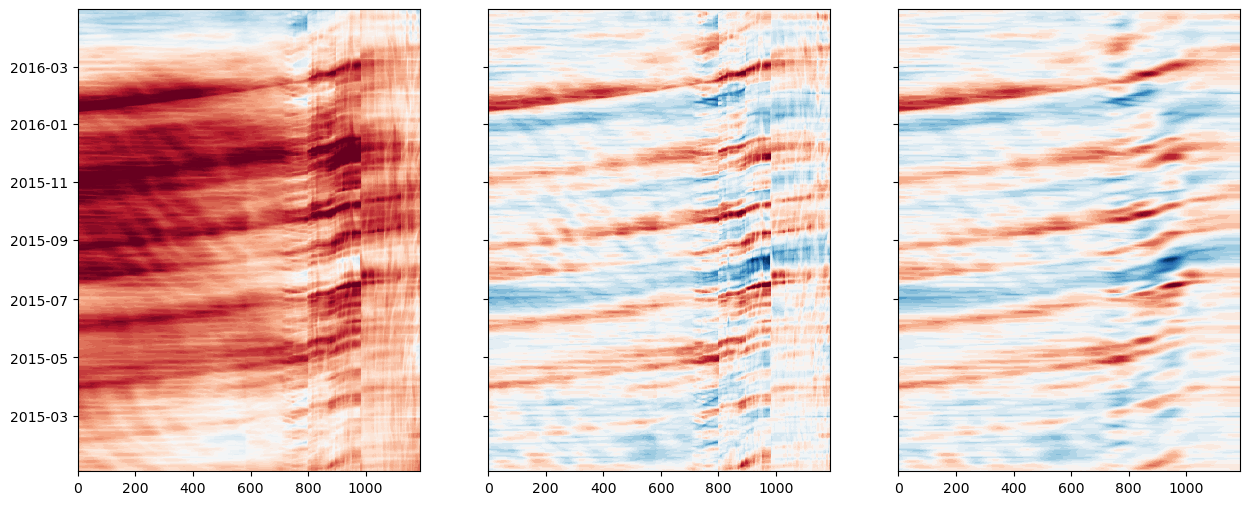

In [133]:
x = north_glorys.sel(time=slice('2015-01','2016-04'))
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, facecolor='w', dpi=100, figsize=(15,6))

ax[0].contourf(x.index, x.time, x.zos*100, cmap='RdBu_r', levels=np.arange(-25,25+1,1), extend='both')
ax[1].contourf(x.index, x.time, filter_xarray(x.zos*100,'time',5, 1/180, btype='highpass').T, cmap='RdBu_r', levels=np.arange(-15,15+1,1), extend='both')
ax[2].contourf(x.index, x.time, filter_xarray(filter_xarray(x.zos*100,'time',5, 1/180, btype='highpass').swap_dims({'index':'distance'}), 'distance', 5, 1/100), cmap='RdBu_r', levels=np.arange(-15,15+1,1), extend='both')

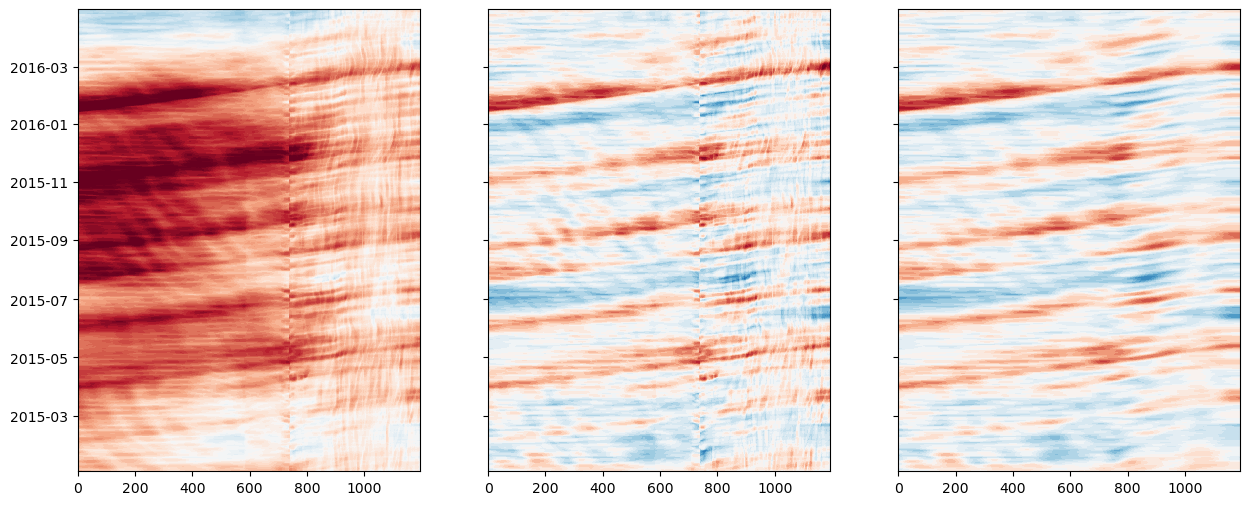

In [137]:
x = south_glorys.sel(time=slice('2015-01','2016-04'))
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, facecolor='w', dpi=100, figsize=(15,6))

ax[0].contourf(x.index, x.time, x.zos*100, cmap='RdBu_r', levels=np.arange(-25,25+1,1), extend='both')
ax[1].contourf(x.index, x.time, filter_xarray(x.zos*100,'time',5, 1/180, btype='highpass').T, cmap='RdBu_r', levels=np.arange(-15,15+1,1), extend='both')
ax[2].contourf(x.index, x.time, filter_xarray(filter_xarray(x.zos*100,'time',5, 1/180, btype='highpass').swap_dims({'index':'distance'}), 'distance', 5, 1/100), cmap='RdBu_r', levels=np.arange(-15,15+1,1), extend='both')